### Random Forrest Framework

In [1]:
class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
#         print(self.n_features, "sha: ",x.shape[1])    
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs=np.array(range(self.sample_sz)),depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
#         print(f_idxs)
#         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [69]:
import pandas as pd
from pandas import DatetimeIndex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import math
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
plt.rcParams['figure.figsize'] = (15, 9)
%matplotlib inline

In [3]:
bitcoin_df = pd.read_excel("CRYPTOCURRENCY/BITCOIN.xlsx")
nvdia_df = pd.read_excel("CRYPTOCURRENCY/NVDA.xlsx")

In [4]:
nvdia_df.head()

,Date,Open,Close,High,Low,Volume,HLC
0,2013-01-02,12.67,12.87,12.58,12.65,72528,12.7425
1,2013-01-03,12.68,13.25,12.68,13.25,124545,13.1075
2,2013-01-04,13.39,13.49,12.68,12.83,144870,13.1225
3,2013-01-07,12.75,12.88,12.40,12.59,113579,12.6875
4,2013-01-08,12.70,12.70,12.13,12.24,167611,12.4425


#### Create Date as index

In [5]:
bitcoin_df.index=DatetimeIndex(bitcoin_df['Date'])
nvdia_df.index=DatetimeIndex(nvdia_df['Date'])

#### Join NVD and Bitcoin datasets

In [6]:
X = bitcoin_df.join(nvdia_df,rsuffix='_nvida')
X["Bitcoin_Price"] = (2*bitcoin_df.High + bitcoin_df.Low + bitcoin_df.Close)/4

In [7]:
X.drop(columns=['Date', 'Open', 'High', 'Low', 'Close','Date_nvida', 'Open ', 'Close ', 'High ', 'Low ','Market Cap'],inplace=True)

In [8]:
X.columns = ['bitcoin_volume','nvd_volume','nvd_price','bitcoin_price']

In [9]:
X.drop(X[X.bitcoin_volume.isnull()].index,inplace=True)
X.drop(X[X.bitcoin_volume == '-'].index,inplace=True)

### Since there are missing values weekends and holidays, we do backfill for NVD values

In [10]:
X['nvd_price'].fillna(method='bfill',inplace=True)

In [11]:
X['nvd_volume'].fillna(method='bfill',inplace=True)

Text(0,0.5,'Nvidia Price')

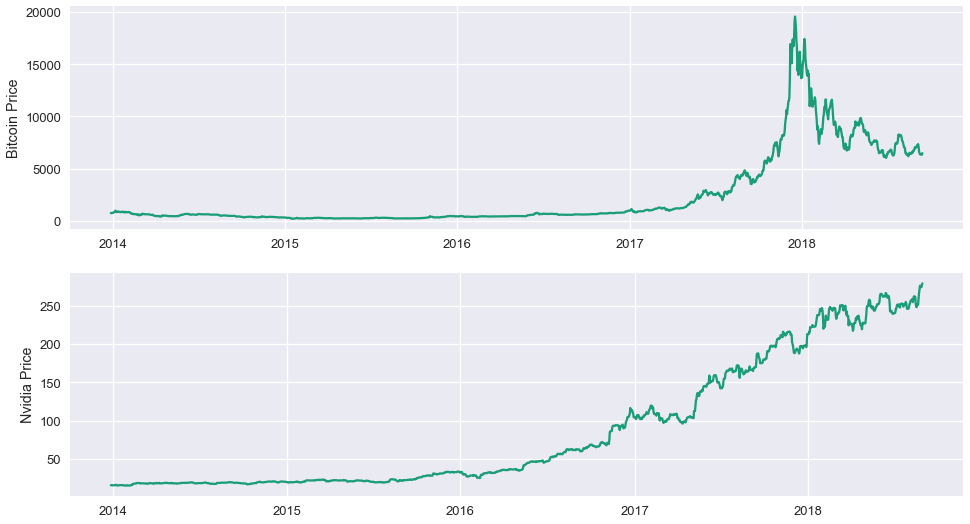

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.plot(X.index,X['bitcoin_price'])
ax1.set_ylabel("Bitcoin Price")
ax2.plot(X.index,X['nvd_price'])
ax2.set_ylabel("Nvidia Price")

### Set bitcoin price as the y

In [13]:
y = X.bitcoin_price

In [14]:
X.drop(['bitcoin_price'],inplace = True,axis=1)

#### Create Random Forrest Structure

In [15]:
rf = RandomForest(x=X,y=y,n_trees=20,n_features=4,sample_sz=500)

C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less_equal
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


In [16]:
tree = rf.create_tree()

C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less_equal
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


In [17]:
y_pred = rf.predict(X.tail(365).values)

#### Comparing predicted values for the last year and actual prices
The prediction follows the trend similar to actual values

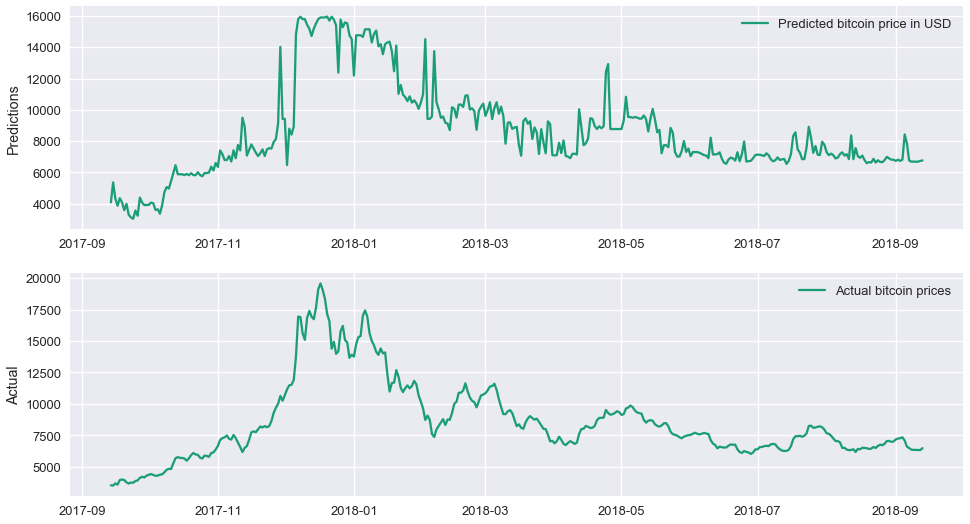

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.plot(X.tail(365).index,y_pred,label="Predicted bitcoin price in USD")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.plot(X.tail(365).index,y.tail(365),label="Actual bitcoin prices")
ax2.legend(loc='best')

### The daily data seems to be noise and has fluctuations, we can try a Moving average 

In [20]:
ema_short = X.ewm(span=7, adjust=False).mean()

In [21]:
y_short = y.ewm(span=7, adjust=False).mean()

In [22]:
rf2 = RandomForest(x=ema_short,y=y_short,n_trees=20,n_features=4,sample_sz=500)

In [23]:
y_pred_short = rf.predict(ema_short.tail(365).values)

In [24]:
rf2.create_tree()

### The flucutations are much less noise than daily predictions and seems more accurate

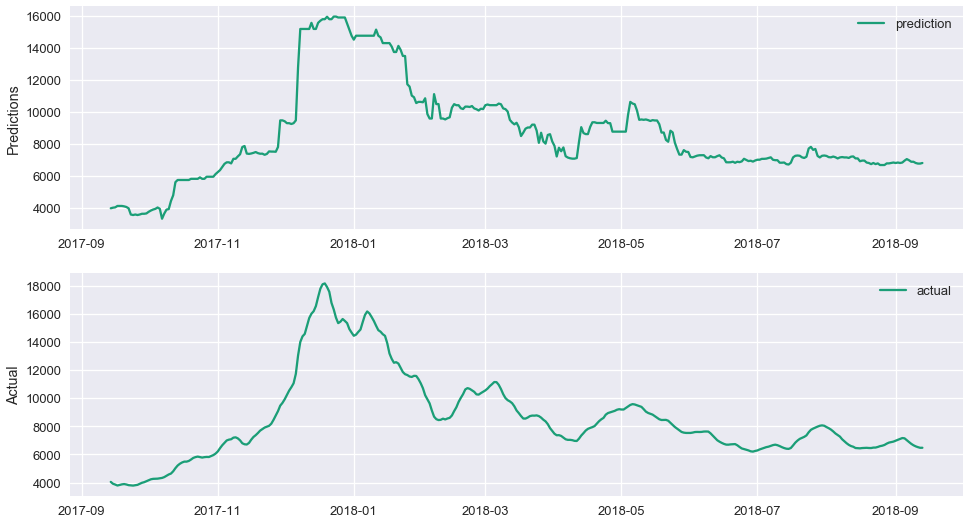

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.plot(ema_short.tail(365).index,y_pred_short,label="prediction")
ax2.plot(X.tail(365).index,y_short.tail(365),label="actual")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [26]:
trading_signal_week = pd.DataFrame(np.sign(np.diff(y_pred_short)),index=X.tail(364).index,columns=["signal"])

In [27]:
trading_signal_week.head()

,signal
Date,
2017-09-15,1.0
2017-09-16,1.0
2017-09-17,1.0
2017-09-18,0.0
2017-09-19,0.0


In [28]:
trading_signal_week = trading_signal_week.shift(1)

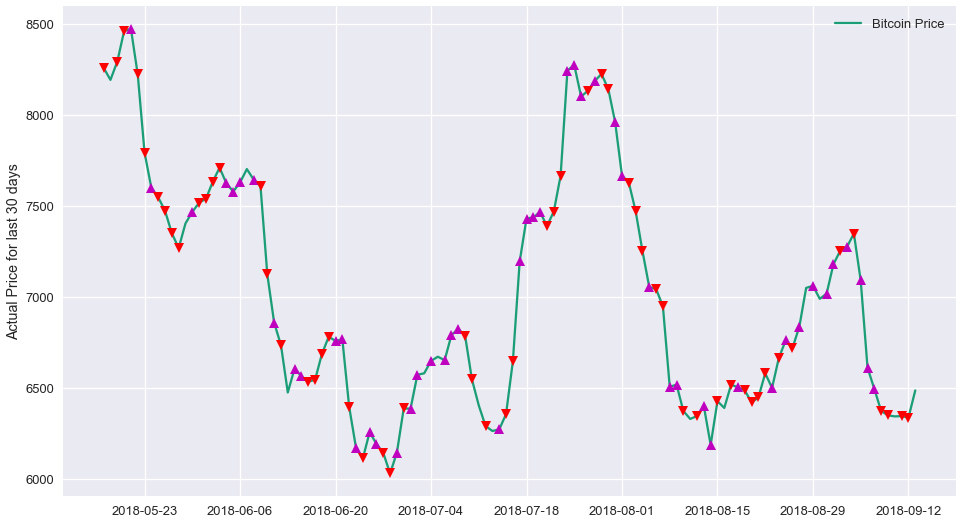

In [29]:
fig, (ax2) = plt.subplots(1, 1, figsize=(16,9))
duration = 120
y_temp = pd.DataFrame(y_short.tail(duration),index =X.tail(duration).index)
ax2.plot(X.tail(duration).index,y.tail(duration),label="Bitcoin Price")

ax2.set_ylabel("Actual Price for last 30 days")

ax2.legend(loc='best')

# # Plot the buy signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == 1.0].index, 
         y.tail(duration)[trading_signal_week.signal == 1.0],'^', markersize=10, color='m')

# Plot the sell signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == -1.0].tail(duration).index, 
         y.tail(duration)[trading_signal_week.signal == -1.0],'v', markersize=10, color='r')

### Backtest with initial capital of $10000

In [36]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=trading_signal_week.index).fillna(0.0)

# Buy 100 coins
positions['bitcoin_price'] = 10*trading_signal_week['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(y_short.tail(365), axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(y_short.tail(365), axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(y_short.tail(365), axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

In [37]:
portfolio = portfolio.loc["2017-09-16":]

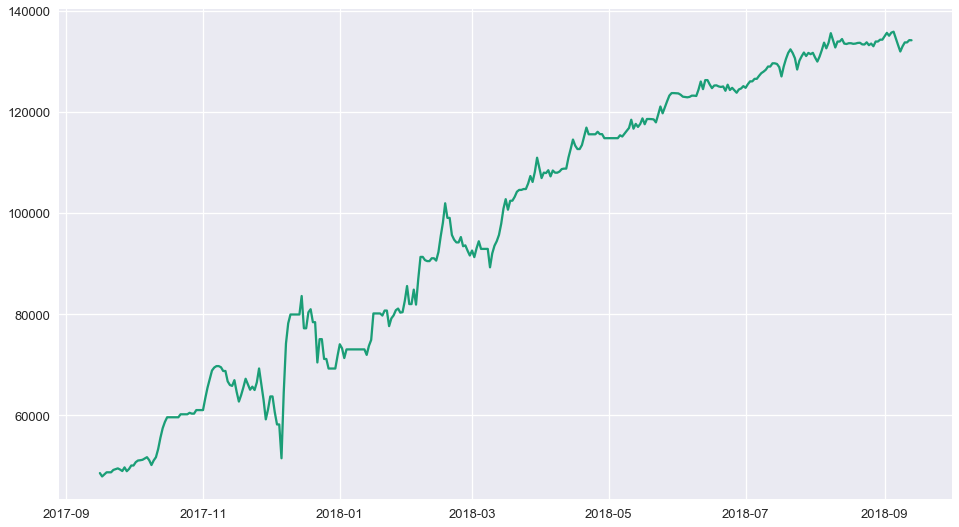

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(16,9))
duration = 120
ax1.plot(portfolio['total'])


### Sharpe Ratio

In [82]:

# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(365) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

1.285548404196041


#### Maximum Drawdown

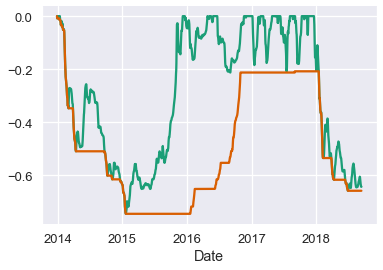

In [46]:

# Define a trailing 252 trading day window
window = 365

# Calculate the max drawdown in the past window days for each day
rolling_max = y_short.rolling(window, min_periods=1).max()
daily_drawdown =y_short/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

### Given the noise in the signal provided by Random Forrest, let's try using Kalman Filter to smooth things out

#### K =1

In [61]:
Y = y_pred
_,_,k_value = KalmanFilter_main(Y,1)

Optimization terminated successfully.
         Current function value: 3342.569807
         Iterations: 216
         Function evaluations: 379
T*u_smooth[-1] is -6731.038446064072; Z*u_tplus1 is 8061.573704184884


#### Plot actual vs Kalman Predictions
The peaks seem to smoothened out

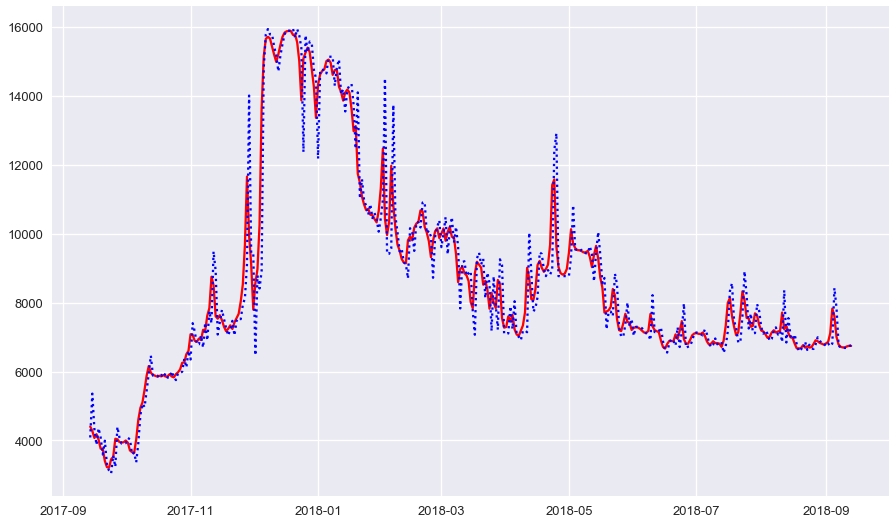

In [70]:
plt.rcParams['figure.figsize'] = (15, 9)
timevec = y.tail(365).index
fig = plt.plot(timevec, -k_value,'r',timevec, Y,'b:')

### Comparing Actual Prices versus Kalman Smoothed Prices

No handles with labels found to put in legend.


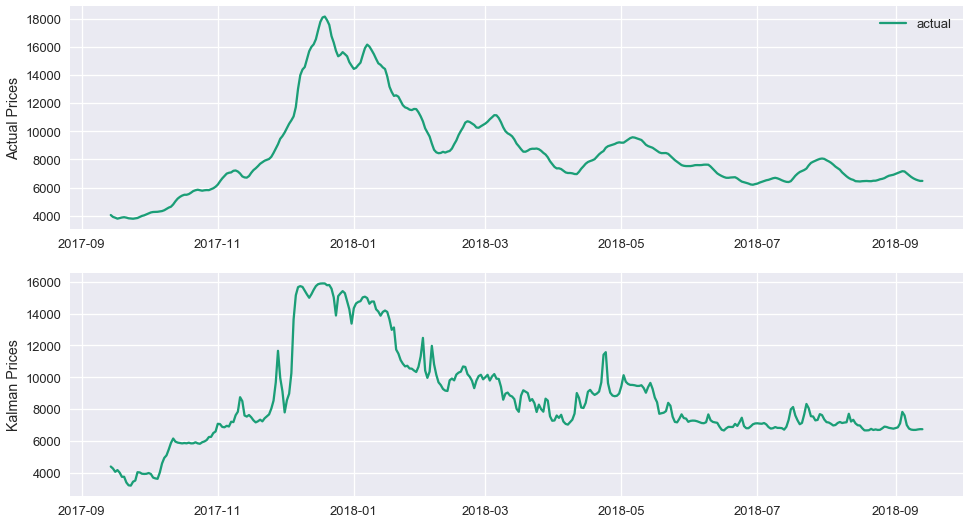

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
#ax1.plot(ema_short.tail(365).index,y_pred_short,label="prediction")
ax1.plot(X.tail(365).index,y_short.tail(365),label="actual")
ax2.plot(X.tail(365).index,-k_value)
ax1.set_ylabel("Actual Prices")
ax2.set_ylabel("Kalman Prices")
ax1.legend(loc='best')
ax2.legend(loc='best')

#### For k=2, we use (Y-Ymean)/Ystd for normalizing values

In [80]:
Y_2=(y_pred-y_pred.mean())/y_pred.std()
_,_,k_value_2 = KalmanFilter_main(Y_2,2)

Optimization terminated successfully.
         Current function value: 711.605086
         Iterations: 169
         Function evaluations: 327
T*u_smooth[-1] is -0.0035746766196124422; Z*u_tplus1 is -5.651985196910989e-09


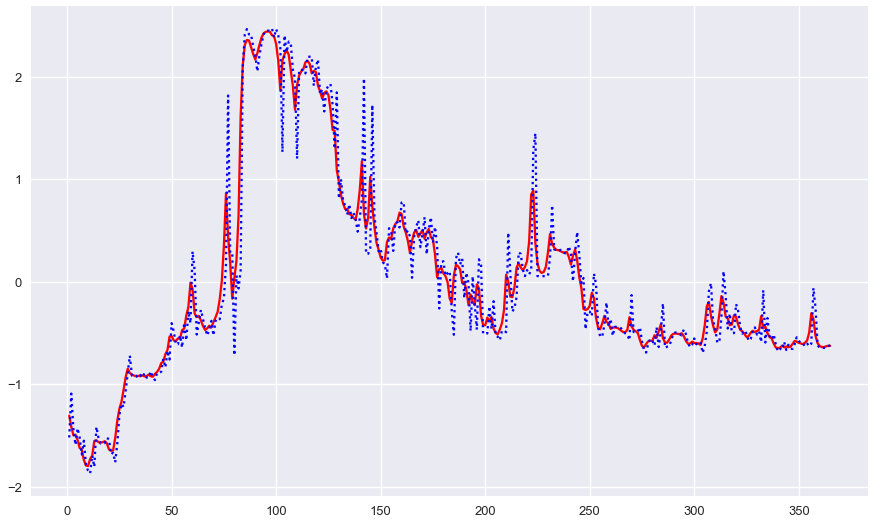

In [81]:
fig = plt.plot(np.linspace(1,365,365), k_value_2[366:],'r',np.linspace(1,365,365), Y_2,'b:')

### Functions defined Below--

In [58]:

from scipy import optimize
def KalmanFilter(R,k,params):
    S_length = R.shape[0]
    S = S_length+1
    if k == 1:
        Z = np.array(2/(1+np.exp(-params[0]))-1)
        H = np.array(np.exp(params[1]))
        T = np.array(2/(1+np.exp(-params[2]))-1)
        Q = np.array(np.exp(params[3]))
    if k == 2:
        Z = np.array([[2/(1+np.exp(-params[0]))-1,2/(1+np.exp(-params[1]))-1]])
        H = np.array(np.exp(params[2]))
        T = np.array([[2/(1+np.exp(-params[3]))-1,0],[0,2/(1+np.exp(-params[4]))-1]])
        Q = np.array([[np.exp(params[5]),0],[0,np.exp(params[6])]])
    u_predict = np.zeros((k,S));
    u_update = np.zeros((k,S));
    P_predict = np.zeros((k,k,S));
    P_update = np.zeros((k,k,S));
    v = np.zeros((1,S));
    F = np.zeros((1,S));
    KF_Dens = np.zeros((1,S));
    for i in range(S):
        if i == 0:
            P_update[:,:,i] = 1000*np.eye(k)
            P_predict[:,:,i] = T.dot(np.array(P_update[0][0][0]).dot(T.T))+Q
        else:
            F[0][i] = Z.dot(P_predict[:,:,i-1].dot(Z.T))+H
            v[0][i] = R.T.flatten()[i-1]-Z.dot(u_predict[:,i-1])
            u_update[:,i] = u_predict[:,i-1]+P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(v[0][i]))).flatten()
            u_predict[:,i] = T.dot(u_update[:,i])
            P_update[:,:,i] = P_predict[:,:,i-1]-P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(Z.dot(P_predict[:,:,i-1]))))
            P_predict[:,:,i] = T.dot(P_update[:,:,i]).dot(T.T)+Q
            KF_Dens[0][i] = (1.0/2)*np.log(2*np.pi)+(1.0/2)*np.log(np.abs(F[0][i]))+(1.0/2)+v[0][i].T*np.linalg.inv([[F[0][i]]])*v[0][i]
    Likelihood = np.sum(KF_Dens)-KF_Dens[0][0]
    varargout = [u_update, P_update, P_predict, T]
    return Likelihood, varargout

In [59]:
def KalmanSmoother(R,k,params_star):
    _,vararg = KalmanFilter(R,k,params_star)
    u_update = vararg[0]
    P_update = vararg[1]
    P_predict = vararg[2]
    T = np.array(vararg[3])
    S = R.shape[0]+1
    u_smooth = np.zeros((k,S))
    P_smooth = np.zeros((k,k,S))
    u_smooth[:,S-1] = u_update[:,S-1]
    P_smooth[:,:,S-1] = P_update[:,:,S-1]    
    for t in reversed(range(1,S)): # 2 to S inverse sequence
        u_smooth[:,t-1] = u_update[:,t] + P_update[:,:,t].dot(T.T.dot(np.linalg.inv(P_predict[:,:,t]).dot((u_smooth[:,t]-T.dot(u_update[:,t])))))
        P_smooth[:,:,t-1] = P_update[:,:,t] + P_update[:,:,t].dot(T.T).dot(np.linalg.inv(P_predict[:,:,t])).dot((P_smooth[:,:,t]-P_predict[:,:,t])).dot(np.linalg.inv(P_predict[:,:,t])).dot(T).dot(P_update[:,:,t])
    u_smooth = u_smooth.flatten()[1:]
    return u_smooth

In [60]:
def KalmanFilter_main(R,k):
    r = 0.25*np.log(np.var(R,axis = 0,ddof=1))
    if k == 1:
        param0 = np.append(np.append(np.append(np.array(100),r,),100),r)
    if k == 2:
        param0 = np.append(np.append(np.append(np.array([100,100]),4*r),[-100,-100]),[r,r])
    def objective(params):
        Likelihood,_ = KalmanFilter(R,k,params)
        return Likelihood
    params_star= optimize.fmin(objective,param0)
    u_smooth = KalmanSmoother(R, k, params_star)
    Z = 2/(1+np.exp(-params_star[0]))-1;
    H = np.exp(params_star[1]);
    T = 2/(1+np.exp(-params_star[2]))-1;
    Q = np.exp(params_star[3]);
      
    u_tplus1 = T*u_smooth[-1] + np.random.normal()*np.sqrt(Q)
    price_tplus1 = Z*u_tplus1 + np.random.normal()*np.sqrt(H)
    print('T*u_smooth[-1] is {}; Z*u_tplus1 is {}'.format(T*u_smooth[-1],Z*u_tplus1))
    return price_tplus1,u_tplus1,u_smooth